In [1]:
import base64
from collections import namedtuple
import csv
import glob
import io
import pandas
import ntpath

from absl import app
from absl import flags
from absl import logging

from apiclient import discovery
from concurrent import futures

In [70]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
FLAGS = flags.FLAGS

flags.DEFINE_string('api_key', None, 'API Key')
flags.DEFINE_string('folder', '', 'Folder where images are located.')
flags.DEFINE_string('results', '', 'File to store image labels.')
flags.DEFINE_boolean('graph', True, 'Analyze labels from results file.')

In [3]:
# Google Cloud information.
_API_NAME = 'vision'
_API_VERSION = 'v1'
_MAX_RESULTS = 10
_NUM_RETRIES = 3

# Image columns.
_MASTER_FIELD = 'master_id'
_FILE_LOCATION = 'path'
_LABELS = 'labels'

# File information.
_FILE_RESULTS = 'images_results.csv'

# Concurrent parameters.
_MAX_WORKERS = 10
_EXECUTOR_TIMEOUT = 60

# API information.
_RESPONSES = 'responses'
_ANNOTATIONS = 'labelAnnotations'
_DESCRIPTION = 'description'

ArtWorkImage = namedtuple('ArtWorkImage', (_MASTER_FIELD, _FILE_LOCATION))

In [4]:
def _GetService(api_key):
    """Gets service instance to start API searches.

    Args:
      api_key: key obtained from https://code.google.com/apis/console.

    Returns:
      A Google API Service used to send requests.
    """

    return discovery.build(_API_NAME, _API_VERSION, developerKey=api_key,
                           cache_discovery=False)


def _IsEmpty(data):
    """Check if Pandas dataFrame is empty or not.

    Args:
        data: (pandas.DataFrame) Dataframe to process.

    Returns:
        A boolean. True if the given data is interpreted as empty
    """

    if data is not None and not data.empty:
        return False
    return True


def LoadDataSet(folder):
    """Reads folder and generates a list of filenames path.

    Args:
      folder: (str) Local or remote readable path.

    Returns:
      A collections.Sequence with tuples of filename and paths.

    Raises:
      FileError: Unable to read filename.
      ValueError: Invalid folder, No data in file.
    """

    if not folder:
        raise ValueError('Invalid folder')

    logging.info('Reading folder: %s.', folder)
    image_list = glob.glob('%s/*.png' % folder)
    image_list.extend(glob.glob('%s/*.jpg' % folder))
    logging.info('Found %d images in folder: %s ', len(image_list), folder)
    return [(ntpath.basename(image), image) for image in image_list]


def LoadResultsFile(filename):
    """Reads filename and generates a Pandas DataFrame with labels.

    Args:
      filename: (str) Local CSV file used as input.

    Returns:
      Pandas.DataFrame: CSV contents.

    Raises:
      FileError: Unable to read filename.
      ValueError: Invalid file, No data in file.
    """

    if not filename:
        raise ValueError('Invalid filename')
    logging.info('Reading file: %s.', filename)
    # Generates a pandas.DataFrame from data in file.
    with open(filename) as input_file:
        dataframe = input_file.read()
    return pandas.read_csv(
        io.BytesIO(dataframe), names=[_MASTER_FIELD, _LABELS],
        header=None)


def SaveDataSet(image_list, filename):
    """Write list of lists in file.

    Args:
      movie_list: (list of sets) The input list to be written.
      filename: (str) Destination file.

    Raises:
      FileError: Unable to read filename.
      ValueError: Movie list is empty.
    """

    if not image_list:
        raise ValueError('Image list is empty')
    logging.info('Saving Image results in %s.', filename)
    # Write results into a file.
    with open(filename, 'w+') as csv_file:
        csv.writer(csv_file).writerows(image_list)


def ExtractImageData(filename):
    """Extract content data from Image.

    Args:
      filename: (str) File of the Image.

    Returns:
      Image content as str.
    """

    with open(filename) as image_file:
        return image_file.read()


def GetImages(image_list):
    """Get a list of file location for each Image in ImageList.

    This method generates a list of Image objects, ArtWorkImage contains
    the Image master_id and path where the Image is located.

    Args:
      image_list: list.

    Returns:
      A collections.Sequence of ArtWorkImage namedtuples.

    Raises:
      ValueError: No Images records found.
    """

    if not image_list:
        raise ValueError('Invalid images')
    return [ArtWorkImage(*image) for image in image_list]


def _ExtractLabels(image):
    """Extract labels from Image using Google Cloud Vision API.

    Args:
      image: (ArtWorkImage) MovieImage object.

    Returns:
      list: List of labels found in Movie image.
    """

    # Initialize Cloud Vision client.
    service = _GetService(FLAGS.api_key)
    if not image.path:
        logging.error('No movie path found for: %s.', image.master_id)
        return
    image_data = ExtractImageData(image.path)
    batch_request = [{
        'image': {
            'content': base64.b64encode(image_data).decode('UTF-8')
        },
        'features': [{
            'type': 'LABEL_DETECTION',
            'maxResults': _MAX_RESULTS,
        }]
    }]
    request = service.images().annotate(body={'requests': batch_request})
    # Send API request to Google Cloud Vision API.
    response = request.execute(num_retries=_NUM_RETRIES)
    return _HandleApiResponse(response)


def _HandleApiResponse(response):
    """Process JSON from API response.

    Args:
      response: (str): string in JSON format.

    Returns:
      A list of labels as a 'bag of words' or empty string if no labels found.

    Raises:
      ValueError: No response.
    """

    if not response:
        raise ValueError('No response')
    if _RESPONSES not in response:
        logging.error('No responses found.')
        return []
    if len(response[_RESPONSES]) != 1:
        logging.error('No labelAnnotations value in responses.')
        return []
    annotations = response[_RESPONSES][0]
    text_labels = []
    # Extract Label annotations.
    if _ANNOTATIONS in annotations:
        for annotation in annotations[_ANNOTATIONS]:
            if _DESCRIPTION in annotation:
                text_labels.append(annotation[_DESCRIPTION])
    logging.info('Number of labels found: %d.', len(text_labels))
    return _GenerateBagOfWords(text_labels)


def _GenerateBagOfWords(list_of_words):
    """Generates a bag of words from a word list.

    Args:
      list_of_words: (list) The list of words (unicode or str).

    Returns:
      (str): List of words as string comma separated.
    """
    if not list_of_words:
        return ''
    # Generate a bag of words from list using comma as default separator.
    return ','.join(
        s.encode('utf-8') if isinstance(s, unicode) else str(s)
        for s in list_of_words)


def ProcessImageList(image_list):
    """Extract labels from image, image resides in CNS or local file.

    Args:
      movies: (list). Contains movie information.

    Returns:
      list: List of tuples (master_id, image labels).

    Raises:
        ValueError: Invalid movie image list.
    """

    if not image_list:
        raise ValueError('Invalid image list')

    image_labels = []
    with futures.ThreadPoolExecutor(max_workers=_MAX_WORKERS) as executor:
        # Start the load operations and mark each future with its Image id.
        future_to_url = {
            executor.submit(_ExtractLabels, image): image for image in
            image_list}
        for future in futures.as_completed(future_to_url):
            image = future_to_url[future]
            try:
                image_labels.append((image.master_id, future.result()))
            except ValueError as e:
                logging.exception('Exception at: %s, %s', image.master_id, e)
    return image_labels


def AnalyzeLabels(dataframe):
    """Analyze labels in text.

    Format:
    MASTER_ID, LABELS
    TheArsenal_1928.png,"art,mural,painting,artwork,recreation"

    :param dataframe:
    :return:
    """
    entities = {}
    for _, labels in dataframe.iterrows():
        for label in labels[1].split(','):
            if entities.get(label):
                entities[label] += 1
            else:
                entities[label] = 1
    return entities

In [9]:
entities = {"infant": 1, "chariot": 1, "glass bottle": 1, "street art": 1, "beak": 2, "yellow": 4, "human": 3, "cucurbita": 1, "chicken": 1, "font": 3, "human behavior": 17, "sunflower": 1, "cup": 2, "gourd": 1, "tourism": 1, "horse like mammal": 7, "sky": 1, "local food": 1, "abbey": 1, "horse tack": 1, "tail": 1, "figurine": 1, "calabaza": 1, "acrylic paint": 11, "place of worship": 3, "food": 1, "material": 8, "ecoregion": 1, "artwork": 110, "lady": 2, "chapel": 3, "recreation": 6, "organ": 1, "costume design": 1, "religious institute": 1, "mammal": 2, "floristry": 2, "picture frame": 1, "sketch": 1, "square": 1, "art": 137, "tree": 5, "mural": 44, "design": 2, "portrait": 12, "girl": 1, "archaeological site": 2, "flower": 18, "leaf": 1, "pattern": 2, "gentleman": 3, "religion": 14, "ancient history": 3, "baptistery": 1, "human body": 1, "bird": 4, "sunflower seed": 1, "stallion": 1, "dome": 1, "illustration": 50, "fictional character": 5, "flower arranging": 1, "drinkware": 1, "visual arts": 55, "wildlife": 1, "medieval architecture": 3, "column": 1, "miniature": 1, "self portrait": 4, "produce": 2, "crucifix": 1, "impressionist": 22, "middle ages": 25, "symmetry": 3, "wall": 1, "carnivoran": 2, "liqueur": 1, "elder": 1, "tableware": 1, "carving": 6, "landscape": 2, "flowering plant": 5, "standing": 1, "horse": 5, "vertebrate": 2, "window": 4, "fiction": 2, "paint": 34, "winter squash": 1, "religious item": 1, "agave": 1, "coffee cup": 1, "man": 1, "comic book": 1, "banana": 1, "vintage clothing": 2, "watercolor paint": 17, "door": 3, "poster": 2, "bird of prey": 1, "still life photography": 10, "child": 3, "floral design": 1, "photograph": 1, "flora": 1, "historic site": 1, "psychedelic art": 1, "gothic architecture": 1, "modern art": 83, "rural area": 1, "interaction": 1, "fauna": 7, "mythology": 19, "history": 14, "ranch": 1, "head": 1, "alley": 1, "rooster": 1, "galliformes": 1, "graphics": 1, "computer wallpaper": 1, "graffiti": 4, "cathedral": 3, "facade": 2, "waterway": 1, "stained glass": 1, "tapestry": 8, "stock photography": 3, "angle": 1, "textile": 2, "shrine": 2, "steppe": 1, "vegetable": 1, "toddler": 1, "disciple": 1, "plant": 9, "tourist attraction": 1, "pack animal": 5, "farm": 1, "fruit": 2, "arch": 4, "cartoon": 2, "hummingbird": 1, "building": 4, "reflection": 1, "painting": 132, "grass": 1, "still life": 28, "fate": 1, "green": 1, "jungle": 1, "bottle": 1, "mythical creature": 2, "organism": 10, "drawing": 2}

In [12]:
def keyfunction(k):
    return entities[k]

In [43]:
top_words = [(key, entities[key]) for key in sorted(entities, key=keyfunction, reverse=True)[:25]]

In [71]:
top_words

[('art', 137),
 ('painting', 132),
 ('artwork', 110),
 ('modern art', 83),
 ('visual arts', 55),
 ('illustration', 50),
 ('mural', 44),
 ('paint', 34),
 ('still life', 28),
 ('middle ages', 25),
 ('impressionist', 22),
 ('mythology', 19),
 ('flower', 18),
 ('human behavior', 17),
 ('watercolor paint', 17),
 ('religion', 14),
 ('history', 14),
 ('portrait', 12),
 ('acrylic paint', 11),
 ('still life photography', 10),
 ('organism', 10),
 ('plant', 9),
 ('material', 8),
 ('tapestry', 8),
 ('horse like mammal', 7)]

In [72]:
N = len(top_words)

In [73]:
x = np.arange(1, N + 1)

In [74]:
y = [num for (s, num) in top_words]

In [75]:
labels = [s for (s, num) in top_words]

In [78]:
width = 0.5

(array([ 1.25,  2.25,  3.25,  4.25,  5.25,  6.25,  7.25,  8.25,  9.25,
        10.25, 11.25, 12.25, 13.25, 14.25, 15.25, 16.25, 17.25, 18.25,
        19.25, 20.25, 21.25, 22.25, 23.25, 24.25, 25.25]),
 <a list of 25 Text xticklabel objects>)

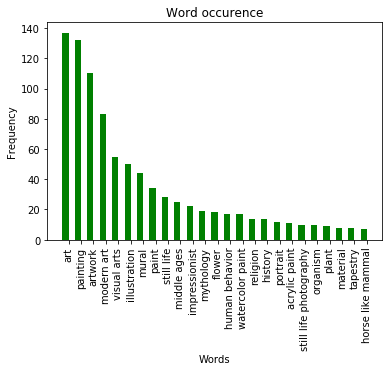

In [87]:
plt.bar(x, y, width, color='g')
plt.ylabel('Frequency')
plt.xlabel('Words')
plt.title('Word occurence')
plt.xticks(x + width/2.0, labels)
plt.xticks(rotation=90)

In [66]:
plt.show()